In [156]:
import pymysql
import numpy as np
import pandas as pd

connection = pymysql.connect(host='1.117.74.41',
                             user='xiecheng',
                             password='xiecheng',
                             database='xiecheng',
                             cursorclass=pymysql.cursors.DictCursor)

with connection:
    with connection.cursor() as cursor:
        sql = "SELECT * FROM  `xiecheng_ticket` order by id desc limit 5000"

        tickets = pd.read_sql(sql, connection)

# 数据预处理

In [157]:
print("特征维度：", tickets.shape[1])
print("数据大小：", tickets.shape[0])
print(tickets.info())

import sys
tickets.iloc[18:20, 10:]

特征维度： 27
数据大小： 5000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5000 non-null   int64         
 1   craft_1             5000 non-null   object        
 2   plane_name_1        5000 non-null   object        
 3   company_1           5000 non-null   object        
 4   craft_2             5000 non-null   object        
 5   plane_name_2        5000 non-null   object        
 6   company_2           5000 non-null   object        
 7   arrival_airport     5000 non-null   object        
 8   arrival_terminal    5000 non-null   object        
 9   arrival_time        5000 non-null   object        
 10  cross_day           5000 non-null   object        
 11  departure_time      5000 non-null   object        
 12  departure_airport   5000 non-null   object        
 13  departure_terminal  5000 non

,cross_day,departure_time,departure_airport,departure_terminal,departure_week,in_time,craft_size,meat,flyman,economy_price,busniess_price,total_time,transit,transit_time,departure_city,arrival_city,create_time
18,0,2022-08-04 12:20:00,浦东机场,浦东T1,周四,100,中机型,,0,1350.0,0.0,7h35m,昆明,1h20m,上海,济南,2022-07-06 10:27:37
19,0,2022-08-04 13:20:00,虹桥机场,虹桥T2,周四,97,中机型,,0,1656.0,4432.0,7h,西安,2h35m,上海,济南,2022-07-06 10:27:37


可以发现所有字段都不存在null类型的值，但这不代表数据都是完整的，可能存在空字符串，下面对空字符串进行处理

In [158]:
tickets.replace(to_replace="^\s*$", regex=True, value=np.nan, inplace=True)
tickets.info()
# tickets.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5000 non-null   int64         
 1   craft_1             5000 non-null   object        
 2   plane_name_1        5000 non-null   object        
 3   company_1           5000 non-null   object        
 4   craft_2             474 non-null    object        
 5   plane_name_2        474 non-null    object        
 6   company_2           474 non-null    object        
 7   arrival_airport     5000 non-null   object        
 8   arrival_terminal    5000 non-null   object        
 9   arrival_time        5000 non-null   object        
 10  cross_day           5000 non-null   object        
 11  departure_time      5000 non-null   object        
 12  departure_airport   5000 non-null   object        
 13  departure_terminal  5000 non-null   object      

1. craft_2、plane_name_2、company_2、transit、transit_time代表中转的航班，大多为空值。--->暂时直接删除行，后期可能单独对这类航班进行分析
2. in_time为准点率，有第三方提供，所以可能没有。--->缺省的以均值填充
3. craft_1、craft_size、meat部分官方没有提供数据，所以也存在少量空值。--->craft_1行删除、craft_size列删除或者以众数填充、meat空值以不提供填充

下面对缺失值处理：

In [159]:
# 先要将一些数据转化为number类型,下面计算需要用到数值类型
def time2num(total_time):
    try:
        if 'm' in total_time and 'h' in total_time:
            hour, minute = total_time.split("h")
            hour = int(hour)
            minute = int(minute.split("m")[0])
        elif 'm' in total_time:
            hour = 0
            minute = int(total_time.strip('m'))
        elif 'h' in total_time:
            minute = 0
            hour = int(total_time.strip('h'))
        else:
            minute = 0
            hour = 0
            print(f"error:{total_time}")
        return minute + hour*60
    except Exception as e:
        print(e, total_time)

def to_int(s):
    global t
    try:
        if not isinstance(s, str):
            return s
        return int(float(s))
    except:
        print("error:", s)


tickets.total_time = tickets.total_time.apply(time2num)
tickets.in_time = tickets.in_time.apply(to_int)
# tickets.departure_week = tickets.departure_week.map({
#     "周一":1,
#     "周二":2,
#     "周三":3,
#     "周四":4,
#     "周五":5,
#     "周六":6,
#     "周七":7,
# })
# tickets_t = tickets.copy(deep=True)
# tickets_t.in_time.apply(to_int).head()

In [160]:
tickets = tickets[tickets[['craft_2', 'plane_name_2', 'company_2', 'transit', 'transit_time']].isna().sum(1)==5]
tickets['in_time'].fillna(value=tickets.in_time.mean(), inplace=True)
tickets.dropna(subset=['craft_1'], inplace=True)
tickets.craft_size.fillna(value=tickets.craft_size.mode(), inplace=True)
tickets.meat.fillna("无餐食", inplace=True)
tickets.dropna(axis=1, inplace=True)
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4526 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  4526 non-null   int64         
 1   craft_1             4526 non-null   object        
 2   plane_name_1        4526 non-null   object        
 3   company_1           4526 non-null   object        
 4   arrival_airport     4526 non-null   object        
 5   arrival_terminal    4526 non-null   object        
 6   arrival_time        4526 non-null   object        
 7   cross_day           4526 non-null   object        
 8   departure_time      4526 non-null   object        
 9   departure_airport   4526 non-null   object        
 10  departure_terminal  4526 non-null   object        
 11  departure_week      4526 non-null   object        
 12  in_time             4526 non-null   float64       
 13  craft_size          4526 non-null   object      

删除一些无用数据

In [165]:
del tickets['id']

KeyError: 'id'

In [195]:
tickets.reset_index(drop=True, inplace=True)
tickets_clean = tickets.copy(deep=True)

异常值处理（箱型图+3sigma原则）

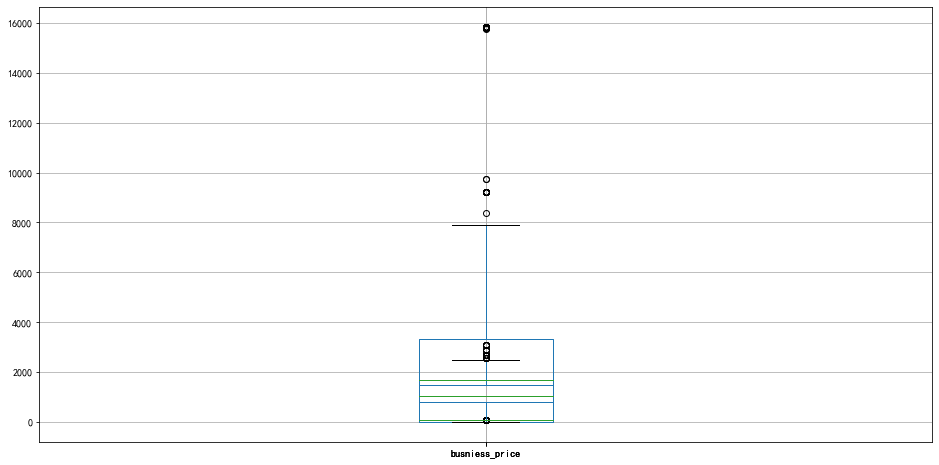

In [241]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16,8))
c = 1
for i in tickets_clean.dtypes.index:
    if tickets_clean.dtypes[i] == np.float:
        # plt.subplot(3, 3, c)
        c += 1
        col = tickets_clean[[i]]
        col.boxplot()
        plt.savefig(f"D:/crawler/box/{i}.png")
plt.show()

由于有些航班没有商务舱的机票或者没有经济舱的机票，存在机票价格为0的情况，所以这里不做异常值处理，后面统计时再进行处理。

In [191]:
# col_economy = np.array(tickets_clean["economy_price"])
# mean_economy = col_economy.mean()
# std_economy = col_economy.std()
# outlier_index = np.arange(col_economy.shape[0])[(col_economy > (mean_economy + 3*std_economy)) | (col_economy < (mean_economy - 3*std_economy))]
# print(outlier_index)
# tickets_clean.drop(outlier_index, axis=0, inplace=True)
#
#
# col_business = np.array(tickets_clean["busniess_price"])
# mean_business = col_business.mean()
# std_business = col_business.std()
# outlier_index = np.arange(col_business.shape[0])[(col_business > (mean_business + 3*std_business)) | (col_business < (mean_business - 3*std_business))]
# print(outlier_index)
# tickets_clean.drop(outlier_index, axis=0, inplace=True)

[ 174  181  182  188  189 1008 1019 1020 1027 1843 1859 1860 1866 1867
 2665 2666 2672 2674 2699 3495 3496 3497 3503 3505 4293 4295 4296 4302
 4303]
[  32   33   34   35   36  860  861  862  863  864 1703 1704 1705 1706
 1707 1712 2514 2522 2525 2526 2527 2528 2529 3348 3350 3351 4123 4125
 4126]


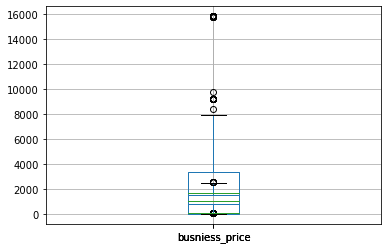

In [193]:
# plt.figure()
# c = 1
# for i in tickets_clean.dtypes.index:
#     if tickets_clean.dtypes[i] == np.float:
#         # plt.subplot(3, 3, c)
#         c += 1
#         col = tickets_clean[[i]]
#         col.boxplot()
#         plt.savefig(f"D:/{i}2.png")
#
# plt.show()


先查看一下数据大致情况

In [194]:
tickets_clean.describe(include=np.number)

,in_time,economy_price,busniess_price,total_time
count,4468.000000,4468.000000,4468.000000,4468.000000
mean,98.466570,1149.716652,2323.501343,149.254700
std,2.141749,464.234636,2314.987672,39.597873
min,87.000000,0.000000,0.000000,85.000000
25%,98.453338,800.000000,0.000000,120.000000
50%,98.453338,1050.000000,1709.500000,145.000000
75%,100.000000,1484.000000,3345.000000,170.000000
max,100.000000,2570.000000,15840.000000,390.000000


In [196]:
tickets_clean.describe(include=np.object)

,craft_1,plane_name_1,company_1,arrival_airport,arrival_terminal,arrival_time,cross_day,departure_time,departure_airport,departure_terminal,departure_week,craft_size,meat,flyman,departure_city,arrival_city
count,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526,4526
unique,58,894,26,19,26,1098,2,1110,2,4,6,3,3,1,1,17
top,波音738(中),东航MU5505,东方航空,宝安机场,宝安T3,2022-08-01 19:00:00,0,2022-08-01 11:25:00,虹桥机场,虹桥T2,周三,中机型,有小食,0,上海,深圳
freq,928,12,1211,604,604,18,4226,12,2720,2291,844,3611,1743,4526,4526,604


# 数据分析

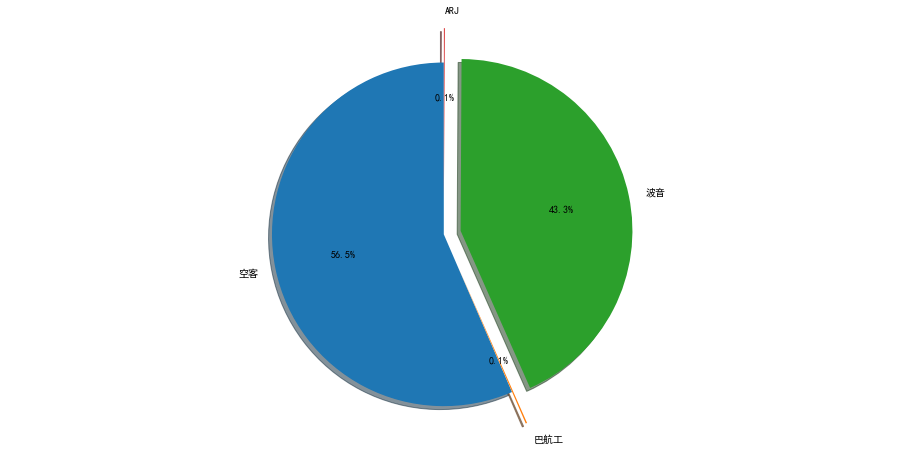

In [242]:
import re
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 飞机型号
craft = tickets_clean['craft_1'].copy(deep=True)
craft = craft.apply(lambda x:re.split("[\d|B]+", x[0:4])[0])
labels = craft.value_counts().index.values
sizes = craft.value_counts().values
t = labels[1]
labels[1] = labels[2]
labels[2] = t
t = sizes[1]
sizes[1] = sizes[2]
sizes[2] = t
explode = (0, 0.2, 0.1, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig = plt.figure(figsize=(16, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("D:/crawler/pie/pie_craft.png")
plt.show()


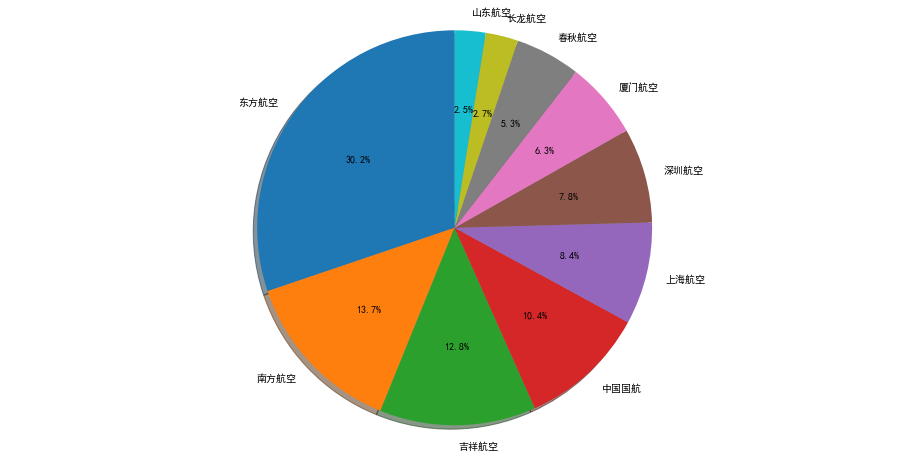

In [243]:
# 航空公司
airline = tickets_clean['company_1'].copy(deep=True)
labels = airline.value_counts().index.values[0:10]
sizes = airline.value_counts().values[0:10]

fig = plt.figure(figsize=(16, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("D:/crawler/pie/pie_airline.png")
plt.show()

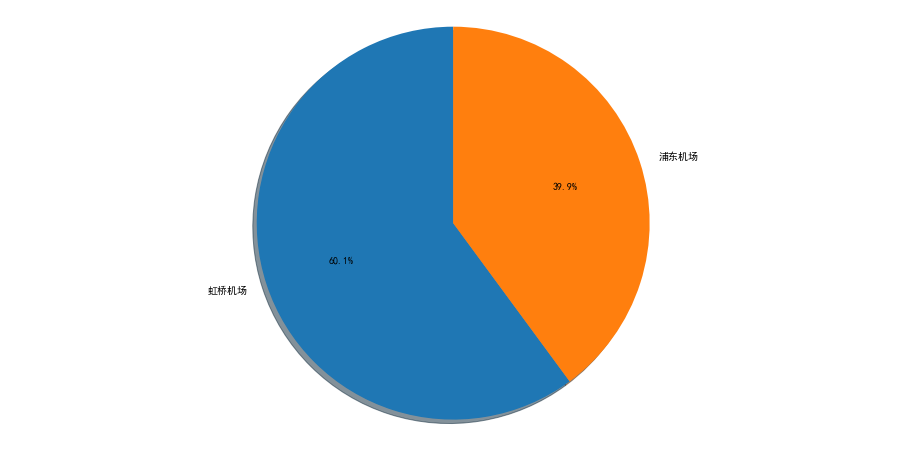

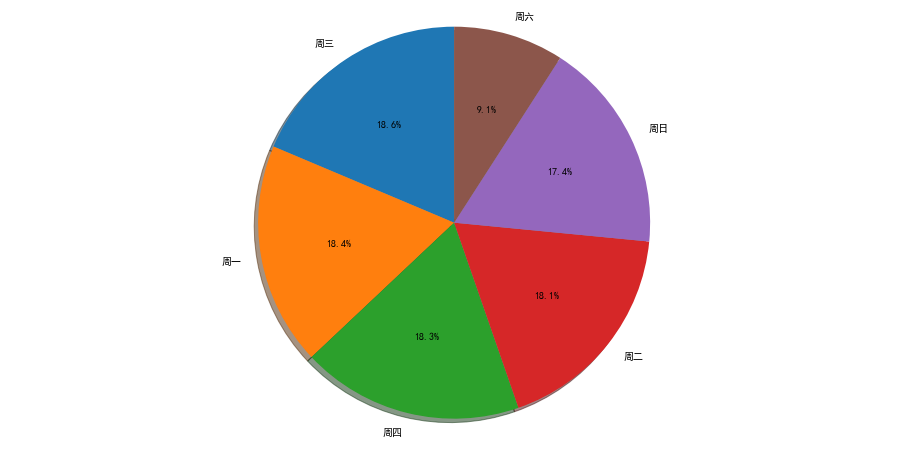

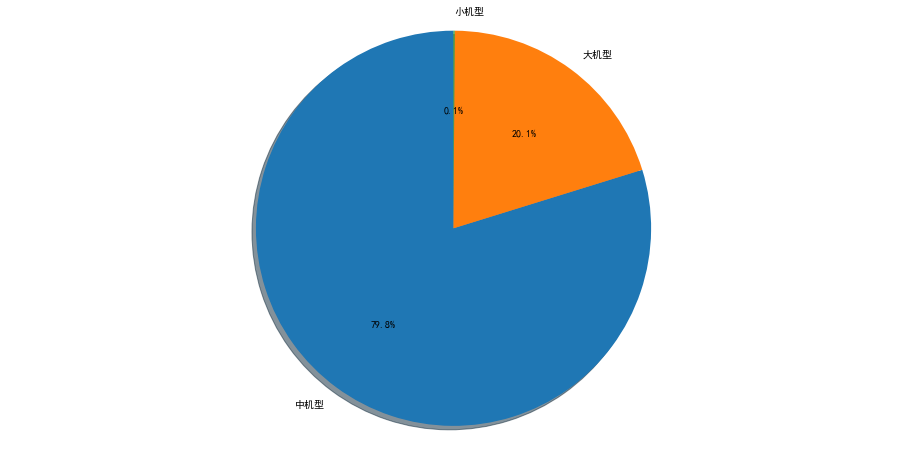

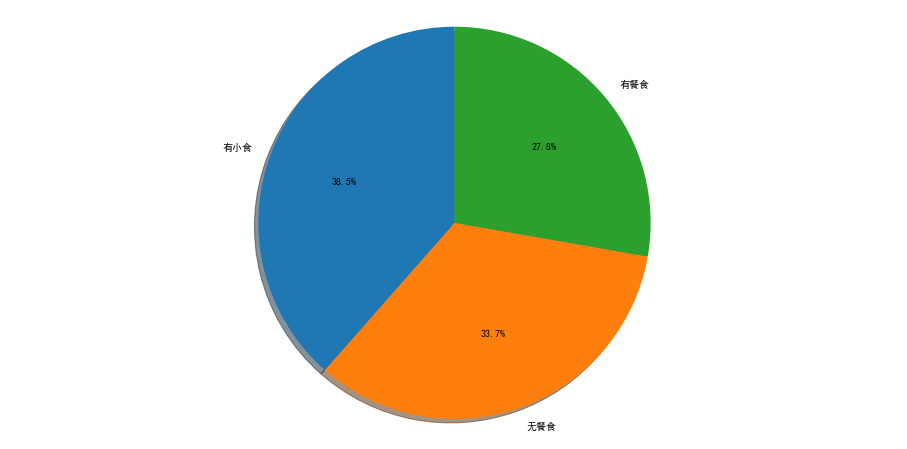

In [244]:
# 对各个字段值的分布进行分析
for col in ["departure_airport", "departure_week", "craft_size", "meat"]:
    columns = tickets_clean[col]
    labels = columns.value_counts().index.values
    sizes = columns.value_counts().values
    fig = plt.figure(figsize=(16, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.savefig(f"D:/crawler/pie/{col}.png")
    plt.show()

In [257]:
# 对准点率进行分析
in_time = tickets_clean['in_time']
print(f"最大准点率:{in_time.max()},对应的航空公司:\n{set(tickets_clean.company_1[in_time.nlargest(20).index.values].values)}")
print(f"准点率均值:{in_time.mean()}")

最大准点率:100.0,对应的航空公司:
{'海航旗下福航', '厦门航空', '中国国航', '吉祥航空', '上海航空', '长龙航空', '山东航空', '西藏航空', '南方航空', '东方航空'}
准点率均值:98.45333811916726


In [306]:
def parse(row):
    print(row, type(row))
# tickets_clean.apply(parse, axis=1)
tickets_clean.arrival_time = pd.to_datetime(tickets_clean.arrival_time)
tickets_clean.departure_time = pd.to_datetime(tickets_clean.departure_time)
tickets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526 entries, 0 to 4525
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   craft_1             4526 non-null   object        
 1   plane_name_1        4526 non-null   object        
 2   company_1           4526 non-null   object        
 3   arrival_airport     4526 non-null   object        
 4   arrival_terminal    4526 non-null   object        
 5   arrival_time        4526 non-null   datetime64[ns]
 6   cross_day           4526 non-null   object        
 7   departure_time      4526 non-null   datetime64[ns]
 8   departure_airport   4526 non-null   object        
 9   departure_terminal  4526 non-null   object        
 10  departure_week      4526 non-null   object        
 11  in_time             4526 non-null   float64       
 12  craft_size          4526 non-null   object        
 13  meat                4526 non-null   object      

In [291]:
import datetime

# 对时间进行分析
def parse_time(s):
    dt = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    hour = dt.hour
    # print(dt)
    if 4 <= hour < 12:
        return 1
    elif 12<= hour < 18:
        return 2
    else:
        return 3

# 对小食进行分析
def parse_meat(s):
    if s == "有小食":
        return 1
    elif s=="有餐食":
        return 2
    else:
        return 3


tickets_numeric = pd.DataFrame({
    'departure_time':[],
    'arrival_time':[],
    'meat':[],
    'in_time':[],
    'total_time':[]
})
tickets_numeric.departure_time = tickets_clean.departure_time.apply(parse_time)
tickets_numeric.arrival_time = tickets_clean.arrival_time.apply(parse_time)
tickets_numeric.meat = tickets_clean.meat.apply(parse_meat)
tickets_numeric.in_time = tickets_clean.in_time
tickets_numeric.ahead = tickets_clean.in_time
# tickets_numeric.economy_price = tickets_clean.economy_price
# tickets_numeric.business = tickets_clean.busniess_price
tickets_numeric.total_time = tickets_clean.total_time
tickets_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526 entries, 0 to 4525
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   departure_time  4526 non-null   int64  
 1   arrival_time    4526 non-null   int64  
 2   meat            4526 non-null   int64  
 3   in_time         4526 non-null   float64
 4   total_time      4526 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 176.9 KB


In [299]:
# 对价格进行分析
from scipy.stats import pearsonr

for col_p in ['economy_price', 'busniess_price']:
    for col in tickets_numeric.columns:
        corr, p = pearsonr(tickets_clean[col_p], tickets_numeric[col])
        if abs(corr) <= 0.2:
            print(f"{col_p}和{col}相关性微小，相关系数为:{corr}({p})")
        elif abs(corr) <=0.5:
            print(f"{col_p}和{col}关系弱，相关系数为:{corr}({p})")
        elif abs(corr) <=0.8:
            print(f"{col_p}和{col}关系强，相关系数为:{corr}({p})")
        else:
            print(f"{col_p}和{col}关系密切，相关系数为:{corr}({p})")

economy_price和departure_time相关性微小，相关系数为:-0.08720428076425246(4.195567643740955e-09)
economy_price和arrival_time相关性微小，相关系数为:-0.029601328005236106(0.04644440263529019)
economy_price和meat相关性微小，相关系数为:-0.0893502616465109(1.7283550511888946e-09)
economy_price和in_time相关性微小，相关系数为:-0.1588643983461128(5.730771916836795e-27)
economy_price和total_time关系弱，相关系数为:0.2084720386851766(1.2673787187861552e-45)
busniess_price和departure_time相关性微小，相关系数为:-0.00755923565114594(0.6111598468041056)
busniess_price和arrival_time相关性微小，相关系数为:0.01953276946753229(0.1888999776523999)
busniess_price和meat相关性微小，相关系数为:-0.11825260669525409(1.4476568314221069e-15)
busniess_price和in_time相关性微小，相关系数为:-0.15432581067766432(1.5925075870785501e-25)
busniess_price和total_time相关性微小，相关系数为:0.12685114487986557(1.0691171589791114e-17)


从皮耳孙系数看出，票价和我们爬取到的这些特征值关联性不强，或者说是存在非线性的关系，所以接下去也不做线性回归的预测，先试试多项式回归看看是否可行。

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
poly = PolynomialFeatures(degree=3)
poly.fit()